In [13]:
import numpy as np
import pandas as pd
import regex as re #A válaszok szövegéből kiszedni a kódcellákat
#import ast #code_snippet_finder függvényben a parseolás teszthez
import transformers
from sklearn.preprocessing import MultiLabelBinarizer
import torch
#import transformers #trainer, trainingarguments
#from transformers import RobertaTokenizer, RobertaForSequenceClassification
#from datasets import Dataset, DatasetDict, load_metric #adatstruktúrák Ács Judit példájából
import matplotlib.pyplot as plt
import matplotlib.patches as pch

In [2]:
#https://www.kaggle.com/datasets/stackoverflow/pythonquestions
#!unzip stackoverflow_python.zip

answers_df = pd.read_csv('Answers.csv', encoding='latin-1')
#questions_df = pd.read_csv('Questions.csv', encoding='latin-1')
tags_df = pd.read_csv('Tags.csv', encoding='latin-1')

In [3]:
tag_dict = {}
for iter_num, ID, tag in tags_df.itertuples():
    try: tag_dict[ID].append(tag)
    except KeyError: tag_dict[ID] = [tag]

tag_count = {}
for iter_num, ID, tag in tags_df.itertuples():
    try: tag_count[tag] += 1
    except KeyError: tag_count[tag] = 1

In [4]:
uncommon_tag_count = 0
for val in tag_count.values():
    if val<=500: uncommon_tag_count+=1
print(uncommon_tag_count, len(tag_count.keys()), len(tag_count.keys())-uncommon_tag_count)

16506 16896 390


In [5]:
tag_count_plot = {}
for count in tag_count.values():
    try: tag_count_plot[count] += 1
    except KeyError: tag_count_plot[count] = 1

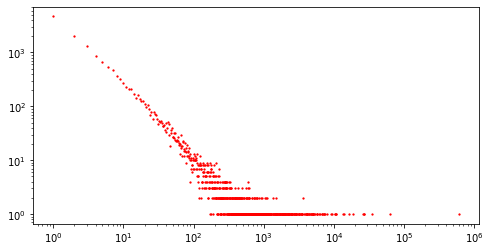

In [6]:
#az x_i koordinátán y_i az érték, ha y_i különböző tag szerepel pontosan x_i-szer

tag_count_plot_x = list(tag_count_plot.keys())
tag_count_plot_y = list(tag_count_plot.values())

plt.figure(figsize=(8,4))
plt.plot(tag_count_plot_x, tag_count_plot_y, 'r.', markersize=2.5)
plt.yscale("log")
plt.xscale("log")

#plt.savefig('tag_count_plot')
plt.show()

#len(tag_count_plot)

In [7]:
def answer_tagger(ID, count):
    global tag_dict, tag_count
    common_tags = []
    for tag in tag_dict[ID]:
        if tag!='python' and tag_count[tag]>=count:
            common_tags.append(tag)
    return common_tags

answers_df['Tags'] = answers_df['ParentId'].map(lambda x:answer_tagger(x,1000))
answers_df.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body,Tags
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...,[osx]
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...,[osx]
2,536,161.0,2008-08-02T18:49:07Z,502,9,<p>You can use ImageMagick's convert utility f...,"[windows, image, pdf]"
3,538,156.0,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...,[]
4,541,157.0,2008-08-02T19:06:40Z,535,20,"<p>We run <a href=""http://buildbot.net/trac"">B...",[]


In [8]:
def code_snippet_finder(comment):
    code_snippets = []
    
    for string in re.split('<code>|/code>', comment):
        if len(string)>3 and string[-1]=='<': #min length
            code_snippets.append(string[:-1])
    return code_snippets

answers_df['CodeSnippets'] = answers_df['Body'].map(code_snippet_finder)
answers_df.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body,Tags,CodeSnippets
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...,[osx],[locate InsertFontHere<br>]
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...,[osx],"[/System/Library/Fonts, /Library/Fonts, ~/Libr..."
2,536,161.0,2008-08-02T18:49:07Z,502,9,<p>You can use ImageMagick's convert utility f...,"[windows, image, pdf]","[Convert taxes.pdf taxes.jpg \n, convert -size..."
3,538,156.0,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...,[],[]
4,541,157.0,2008-08-02T19:06:40Z,535,20,"<p>We run <a href=""http://buildbot.net/trac"">B...",[],[]


In [9]:
df = answers_df.drop(answers_df[answers_df["CodeSnippets"].map(len) == 0].index)
df = df.drop(df[df.Tags.map(len) == 0].index)
#df["TestCode"] = df["CodeSnippets"].map(lambda x:max(x, key=len))
df.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body,Tags,CodeSnippets
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...,[osx],[locate InsertFontHere<br>]
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...,[osx],"[/System/Library/Fonts, /Library/Fonts, ~/Libr..."
2,536,161.0,2008-08-02T18:49:07Z,502,9,<p>You can use ImageMagick's convert utility f...,"[windows, image, pdf]","[Convert taxes.pdf taxes.jpg \n, convert -size..."
5,595,116.0,2008-08-03T01:17:36Z,594,25,<p>The canonical way is to use the built-in cu...,"[sql, database]",[curs.execute('select * from people')\nfor row...
7,701,111.0,2008-08-03T14:30:50Z,683,3,"<p>No, you were not dreaming. Python has a pr...","[arrays, iteration]",[ files = os.listdir(path) ...


In [10]:
tokenizer = transformers.AutoTokenizer.from_pretrained("huggingface/CodeBERTa-small-v1")

def snippet_length_filtering(snippet_list, lowerBound=20, upperBound=512):
    filtered_list = []
    
    for snippet in snippet_list:
        length = len(tokenizer(snippet)['input_ids'])
        if length >= lowerBound and length <= upperBound:
            filtered_list.append(snippet)
    return filtered_list

In [11]:
df["FilteredSnippets"] = df["CodeSnippets"].map(
    lambda x:snippet_length_filtering(x))
df = df.drop(
    df[df["FilteredSnippets"].map(len) == 0].index)
df["TestCode"] = df["FilteredSnippets"].map(lambda x:max(x, key=len))

Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors


In [34]:
oneHot = MultiLabelBinarizer()
oneHot.fit(df["Tags"])
labels = oneHot.transform(df["Tags"])
oneHot.__dict__

{'classes': None,
 'sparse_output': False,
 '_cached_dict': {'ajax': 0,
  'algorithm': 1,
  'amazon-web-services': 2,
  'anaconda': 3,
  'android': 4,
  'apache': 5,
  'apache-spark': 6,
  'api': 7,
  'argparse': 8,
  'arrays': 9,
  'audio': 10,
  'authentication': 11,
  'bash': 12,
  'beautifulsoup': 13,
  'boto': 14,
  'c': 15,
  'c#': 16,
  'c++': 17,
  'celery': 18,
  'cgi': 19,
  'class': 20,
  'csv': 21,
  'ctypes': 22,
  'cython': 23,
  'database': 24,
  'dataframe': 25,
  'date': 26,
  'datetime': 27,
  'debugging': 28,
  'decorator': 29,
  'dictionary': 30,
  'django': 31,
  'django-admin': 32,
  'django-forms': 33,
  'django-models': 34,
  'django-queryset': 35,
  'django-rest-framework': 36,
  'django-templates': 37,
  'django-views': 38,
  'eclipse': 39,
  'elementtree': 40,
  'email': 41,
  'encoding': 42,
  'encryption': 43,
  'excel': 44,
  'exception': 45,
  'facebook': 46,
  'file': 47,
  'file-io': 48,
  'flask': 49,
  'flask-sqlalchemy': 50,
  'for-loop': 51,
  'form

In [35]:
labels.shape

(486030, 206)

In [38]:
df = df.drop(columns=["Id", "OwnerUserId", "CreationDate", "ParentId", "Score", "Body", "label"])
df.head()

,Tags,CodeSnippets,FilteredSnippets,TestCode
2,"[windows, image, pdf]","[Convert taxes.pdf taxes.jpg \n, convert -size...",[convert -size 120x120 taxes.jpg.0 -geometry 1...,convert -size 120x120 taxes.jpg.0 -geometry 12...
5,"[sql, database]",[curs.execute('select * from people')\nfor row...,[curs.execute('select * from people')\nfor row...,curs.execute('select first_name from people')\...
7,"[arrays, iteration]",[ files = os.listdir(path) ...,[ files = os.listdir(path) ...,files = os.listdir(path) ...
8,"[arrays, iteration]","[#!/bin/python<br>bar in dict(Foo)<br>, has_ke...","[#!/bin/python<br>baz = dict([(key, value) for...","#!/bin/python<br>baz = dict([(key, value) for ..."
9,"[arrays, iteration]",[result = [obj for obj in listOfObjs if hasatt...,[result = [obj for obj in listOfObjs if hasatt...,result = [obj for obj in listOfObjs if hasattr...


In [41]:
df.to_json("PyCodes.json")

**innentől csupa szemét a kód**

In [ ]:
pipe = transformers.pipeline(
    'feature-extraction',
    model="huggingface/CodeBERTa-small-v1",
    tokenizer="huggingface/CodeBERTa-small-v1"
)

In [22]:
def debug_fv(code):
    try:
        return pipe(code)
    except Exception:
        print(code + "\n************************************")
        return ("ERROR")
#df["features"] = df["TestCode"].map(debug_fv)

&gt;&gt;&gt; from lxml import etree

&gt;&gt;&gt; from lxml.builder import E

&gt;&gt;&gt; def CLASS(*args): # class is a reserved word in Python
...     return {"class":' '.join(args)}

&gt;&gt;&gt; html = page = (
...   E.html(       # create an Element called "html"
...     E.head(
...       E.title("This is a sample document")
...     ),
...     E.body(
...       E.h1("Hello!", CLASS("title")),
...       E.p("This is a paragraph with ", E.b("bold"), " text in it!"),
...       E.p("This is another paragraph, with a", "\n      ",
...         E.a("link", href="http://www.python.org"), "."),
...       E.p("Here are some reserved characters: &lt;spam&amp;egg&gt;."),
...       etree.XML("&lt;p&gt;And finally an embedded XHTML fragment.&lt;/p&gt;"),
...     )
...   )
... )

&gt;&gt;&gt; print(etree.tostring(page, pretty_print=True))
&lt;html&gt;
  &lt;head&gt;
    &lt;title&gt;This is a sample document&lt;/title&gt;
  &lt;/head&gt;
  &lt;body&gt;
    &lt;h1 class="title"&gt;Hello!&lt;/h1&

def make_hook(f):
    """Decorator to turn 'foo' method into '__foo__'"""
    f.is_hook = 1
    return f

class MyType(type):
    def __new__(cls, name, bases, attrs):

        if name.startswith('None'):
            return None

        # Go over attributes and see if they should be renamed.
        newattrs = {}
        for attrname, attrvalue in attrs.iteritems():
            if getattr(attrvalue, 'is_hook', 0):
                newattrs['__%s__' % attrname] = attrvalue
            else:
                newattrs[attrname] = attrvalue

        return super(MyType, cls).__new__(cls, name, bases, newattrs)

    def __init__(self, name, bases, attrs):
        super(MyType, self).__init__(name, bases, attrs)

        # classregistry.register(self, self.interfaces)
        print "Would register class %s now." % self

    def __add__(self, other):
        class AutoClass(self, other):
            pass
        return AutoClass
        # Alternatively, to autogenerate the classname as well as

def getIPAddresses():
    from ctypes import Structure, windll, sizeof
    from ctypes import POINTER, byref
    from ctypes import c_ulong, c_uint, c_ubyte, c_char
    MAX_ADAPTER_DESCRIPTION_LENGTH = 128
    MAX_ADAPTER_NAME_LENGTH = 256
    MAX_ADAPTER_ADDRESS_LENGTH = 8
    class IP_ADDR_STRING(Structure):
        pass
    LP_IP_ADDR_STRING = POINTER(IP_ADDR_STRING)
    IP_ADDR_STRING._fields_ = [
        ("next", LP_IP_ADDR_STRING),
        ("ipAddress", c_char * 16),
        ("ipMask", c_char * 16),
        ("context", c_ulong)]
    class IP_ADAPTER_INFO (Structure):
        pass
    LP_IP_ADAPTER_INFO = POINTER(IP_ADAPTER_INFO)
    IP_ADAPTER_INFO._fields_ = [
        ("next", LP_IP_ADAPTER_INFO),
        ("comboIndex", c_ulong),
        ("adapterName", c_char * (MAX_ADAPTER_NAME_LENGTH + 4)),
        ("description", c_char * (MAX_ADAPTER_DESCRIPTION_LENGTH + 4)),
        ("addressLength", c_uint),
        ("address", c_ubyte * MAX_ADAPTER_ADDRESS_LENGTH),
        ("index", c_ul

&gt;&gt;&gt; from urllib import urlencode
&gt;&gt;&gt; params = urlencode({'q': 'python best practices', 'sort': 'relevance'})
&gt;&gt;&gt; params
'q=python+best+practices&amp;sort=relevance'
&gt;&gt;&gt; from urllib2 import urlopen
&gt;&gt;&gt; html = urlopen("http://stackoverflow.com/search?%s" % params).read()
&gt;&gt;&gt; import re
&gt;&gt;&gt; links = re.findall(r'&lt;h3&gt;&lt;a href="([^"]*)" class="answer-title"&gt;([^&lt;]*)&lt;/a&gt;&lt;/h3&gt;', html)
&gt;&gt;&gt; links
[('/questions/5119/what-are-the-best-rss-feeds-for-programmersdevelopers#5150', 'What are the best RSS feeds for programmers/developers?'), ('/questions/3088/best-ways-to-teach-a-beginner-to-program#13185', 'Best ways to teach a beginner to program?'), ('/questions/13678/textual-versus-graphical-programming-languages#13886', 'Textual versus Graphical Programming Languages'), ('/questions/58968/what-defines-pythonian-or-pythonic#59877', 'What defines &amp;#8220;pythonian&amp;#8221; or &amp;#8220;pythonic&amp;#

import wx
import wx.lib.newevent


(PageChangeEvent, EVT_PAGE_CHANGE) = wx.lib.newevent.NewEvent()


class Data:
    foo = None
    bar = None


class Page1(wx.Panel):
    def __init__(self, parent, data):
        wx.Panel.__init__(self, parent)
        self.parent = parent
        self.data = data

        sizer = wx.BoxSizer(wx.VERTICAL)
        self.SetSizer(sizer)
        label = wx.StaticText(self, label="Page 1 - foo")
        self.foo = wx.TextCtrl(self)
        goto_page2 = wx.Button(self, label="Go to page 2")

        for c in (label, self.foo, goto_page2):
            sizer.Add(c, 0, wx.TOP, 5)

        goto_page2.Bind(wx.EVT_BUTTON, self.OnPage2)

    def OnPage2(self, event):
        self.data.foo = self.foo.Value
        wx.PostEvent(self.parent, PageChangeEvent(page=Page2))


class Page2(wx.Panel):
    def __init__(self, parent, data):
        wx.Panel.__init__(self, parent)
        self.parent = parent
        self.data = data

        sizer = wx.BoxSizer(wx.VERTICAL)
 

import psyco
import time
import cStringIO

def time_func(func):
    """The amount of time it requires func to run"""
    start = time.clock()
    func()
    return time.clock() - start

def fizzbuzz(num):
    """That algorithm we all know and love"""
    if not num % 3 and not num % 5:
        return "%d fizz buzz" % num
    elif not num % 3:
        return "%d fizz" % num
    elif not num % 5:
        return "%d buzz" % num
    return None

def with_list(num):
    """Try getting fizzbuzz with a list comprehension and range"""
    out = cStringIO.StringIO()
    for fibby in [fizzbuzz(x) for x in range(1, num) if fizzbuzz(x)]:
        print &gt;&gt; out, fibby
    return out.getvalue()

def with_genx(num):
    """Try getting fizzbuzz with generator expression and xrange"""
    out = cStringIO.StringIO()
    for fibby in (fizzbuzz(x) for x in xrange(1, num) if fizzbuzz(x)):
        print &gt;&gt; out, fibby
    return out.getvalue()

def main():
    """
    Test speed of generator expres

#!usr/bin/env python

import wx

class TestFrame(wx.Frame):
    def __init__(self, parent, *args, **kwargs):
        wx.Frame.__init__(self, parent, *args, **kwargs)
        framesizer = wx.BoxSizer(wx.VERTICAL)
        mainpanel = MainPanel(self, wx.ID_ANY)
        self.subpanel = SubPanel(self, wx.ID_ANY)
        self.subpanel.Hide()
        framesizer.Add(mainpanel, 1, wx.EXPAND)
        framesizer.Add(self.subpanel, 1, wx.EXPAND)
        self.SetSizerAndFit(framesizer)

class MainPanel(wx.Panel):
    def __init__(self, parent, *args, **kwargs):
        wx.Panel.__init__(self, parent, *args, **kwargs)
        panelsizer = wx.BoxSizer(wx.VERTICAL)
        but = wx.Button(self, wx.ID_ANY, "Add")
        self.Bind(wx.EVT_BUTTON, self.OnAdd, but)
        self.panel_shown = False
        panelsizer.Add(but, 0)
        self.SetSizer(panelsizer)

    def OnAdd(self, evt):
        if not self.panel_shown:
            self.GetParent().subpanel.Show()
            self.GetParent().Fit()
      

"""
&gt;&gt;&gt; from models import *

Create some food records

&gt;&gt;&gt; weed = Food(name="weed")
&gt;&gt;&gt; weed.save()

&gt;&gt;&gt; burger = Food(name="burger")
&gt;&gt;&gt; burger.save()

&gt;&gt;&gt; pet_food = Food(name="Pet food")
&gt;&gt;&gt; pet_food.save()

John the farmer likes burgers

&gt;&gt;&gt; john = Person(first_name="John", last_name="Farmer", birth_date="1960-10-12")
&gt;&gt;&gt; john.save()
&gt;&gt;&gt; john.foods.create(food=burger)
&lt;ConsumedFood: ConsumedFood object&gt;

Wilma the cow eats weed

&gt;&gt;&gt; wilma = Cow(farmer=john)
&gt;&gt;&gt; wilma.save()
&gt;&gt;&gt; wilma.foods.create(food=weed)
&lt;ConsumedFood: ConsumedFood object&gt;

Felix the cat likes pet food

&gt;&gt;&gt; felix = Cat(name="felix")
&gt;&gt;&gt; felix.save()
&gt;&gt;&gt; pet_food.eaters.create(eaten_by=felix)
&lt;ConsumedFood: ConsumedFood object&gt;

What food john likes again ?
&gt;&gt;&gt; john.foods.all()[0].food.name
u'burger'

Who's getting pet food ?
&gt;&gt;&gt; livin

from BitVector import BitVector
from random import Random
# get hashes from http://www.partow.net/programming/hashfunctions/index.html
from hashes import RSHash, JSHash, PJWHash, ELFHash, DJBHash


#
# ryan.a.cox@gmail.com / www.asciiarmor.com
#
# copyright (c) 2008, ryan cox
# all rights reserved 
# BSD license: http://www.opensource.org/licenses/bsd-license.php
#

class BloomFilter(object):
    def __init__(self, n=None, m=None, k=None, p=None, bits=None ):
        self.m = m
        if k &gt; 4 or k &lt; 1:
            raise Exception('Must specify value of k between 1 and 4')
        self.k = k
        if bits:
            self.bits = bits
        else:
            self.bits = BitVector( size=m )
        self.rand = Random()
        self.hashes = []
        self.hashes.append(RSHash)
        self.hashes.append(JSHash)
        self.hashes.append(PJWHash)
        self.hashes.append(DJBHash)

        # switch between hashing techniques
        self._indexes = self._rand_indexes
      

import math

def utmToLatLng(zone, easting, northing, northernHemisphere=True):
    if not northernHemisphere:
        northing = 10000000 - northing

    a = 6378137
    e = 0.081819191
    e1sq = 0.006739497
    k0 = 0.9996

    arc = northing / k0
    mu = arc / (a * (1 - math.pow(e, 2) / 4.0 - 3 * math.pow(e, 4) / 64.0 - 5 * math.pow(e, 6) / 256.0))

    ei = (1 - math.pow((1 - e * e), (1 / 2.0))) / (1 + math.pow((1 - e * e), (1 / 2.0)))

    ca = 3 * ei / 2 - 27 * math.pow(ei, 3) / 32.0

    cb = 21 * math.pow(ei, 2) / 16 - 55 * math.pow(ei, 4) / 32
    cc = 151 * math.pow(ei, 3) / 96
    cd = 1097 * math.pow(ei, 4) / 512
    phi1 = mu + ca * math.sin(2 * mu) + cb * math.sin(4 * mu) + cc * math.sin(6 * mu) + cd * math.sin(8 * mu)

    n0 = a / math.pow((1 - math.pow((e * math.sin(phi1)), 2)), (1 / 2.0))

    r0 = a * (1 - e * e) / math.pow((1 - math.pow((e * math.sin(phi1)), 2)), (3 / 2.0))
    fact1 = n0 * math.tan(phi1) / r0

    _a1 = 500000 - easting
    dd0 = _a1 / (n0 * k0)


from decimal import Decimal

def nth_root(num_decimal, n_integer):
    exponent = Decimal("1.0") / Decimal(n_integer)
    return num_decimal ** exponent

def test():
    ns = "11968003966030964356885611480383408833172346450467339251196093144141045683463085291115677488411620264826942334897996389485046262847265769280883237649461122479734279424416861834396522819159219215308460065265520143082728303864638821979329804885526557893649662037092457130509980883789368448042961108430809620626059287437887495827369474189818588006905358793385574832590121472680866521970802708379837148646191567765584039175249171110593159305029014037881475265618958103073425958633163441030267478942720703134493880117805010891574606323700178176718412858948243785754898788359757528163558061136758276299059029113119763557411729353915848889261125855717014320045292143759177464380434854573300054940683350937992500211758727939459249163046465047204851616590276724564411037216844005877918224201569391107769029955591465502737961776799311

"""Rate limiters with shared token bucket."""

import os
import sys
import threading
import time
import urllib
import urlparse

class TokenBucket(object):
    """An implementation of the token bucket algorithm.
    source: http://code.activestate.com/recipes/511490/

    &gt;&gt;&gt; bucket = TokenBucket(80, 0.5)
    &gt;&gt;&gt; print bucket.consume(10)
    True
    &gt;&gt;&gt; print bucket.consume(90)
    False
    """
    def __init__(self, tokens, fill_rate):
        """tokens is the total tokens in the bucket. fill_rate is the
        rate in tokens/second that the bucket will be refilled."""
        self.capacity = float(tokens)
        self._tokens = float(tokens)
        self.fill_rate = float(fill_rate)
        self.timestamp = time.time()
        self.lock = threading.RLock()

    def consume(self, tokens):
        """Consume tokens from the bucket. Returns 0 if there were
        sufficient tokens, otherwise the expected time until enough
        tokens become available."""

import wx


class TestDropTarget(wx.TextDropTarget):
    def OnDropText(self, x, y, text):
        wx.GetApp().TopWindow.HandleDrop(text)

    def OnDragOver(self, x, y, d):
        return wx.DragCopy


class Test(wx.Frame):
    def __init__(self):
        wx.Frame.__init__(self, None)

        self.numbers = wx.ListCtrl(self, style = wx.LC_ICON | wx.LC_AUTOARRANGE)
        self.field = wx.TextCtrl(self)

        sizer = wx.FlexGridSizer(2, 2, 5, 5)
        sizer.AddGrowableCol(1)
        sizer.AddGrowableRow(0)
        self.SetSizer(sizer)
        sizer.Add(wx.StaticText(self, label="Drag from:"))
        sizer.Add(self.numbers, flag=wx.EXPAND)
        sizer.Add(wx.StaticText(self, label="Drag to:"), flag=wx.ALIGN_CENTER_VERTICAL)
        sizer.Add(self.field)

        for i in range(100):
            self.numbers.InsertStringItem(self.numbers.GetItemCount(), str(i))

        self.numbers.Bind(wx.EVT_LIST_BEGIN_DRAG, self.On_ElementDrag)
        self.field.SetDropTarget(TestDropTarget

import random

def build_tree(pairs):
    tree = Empty()
    for value, weight in pairs:
        tree = tree.add(Leaf(weight, value))
    return tree

def transfer(from_tree, to_tree):
    """Given a nonempty tree and a target, move a leaf from the former to
    the latter. Return the two updated trees."""
    leaf, from_tree1 = from_tree.extract()
    return from_tree1, to_tree.add(leaf)

class Tree:
    def add(self, leaf):
        "Return a new tree holding my leaves plus the given leaf."
        abstract
    def sample(self):
        "Pick one of my leaves at random in proportion to its weight."
        return self.sampling(random.uniform(0, self.weight))
    def extract(self):
        """Pick one of my leaves and return it along with a new tree
        holding my leaves minus that one leaf."""
        return self.extracting(random.uniform(0, self.weight))        

class Empty(Tree):
    weight = 0
    def __repr__(self):
        return 'Empty()'
    def add(self, leaf):
        re

import unittest
import get_nodes

class TestSuper(unittest.TestCase):
    def setUp( self ):
        self.root = get_nodes.mmnode_plus.factory('mytree.xml')
    def condition( self, aNode, skip_traversal, skip_as_child, skip_as_parent, is_leaf ):
        self.assertEquals( skip_traversal, aNode.skip_traversal )
        self.assertEquals( skip_as_child, aNode. skip_as_child)
        self.assertEquals( skip_as_parent, aNode. skip_as_parent)
        self.assertEquals( is_leaf , aNode. is_leaf )

class TestRoot( TestSuper ):
    def testRoot( self ):
        self.condition( self.root, **{'skip_traversal': False, 'skip_as_child': True, 'skip_as_parent': False, 'is_leaf': False} )

class TestRoot0( TestSuper ):
    def testRoot0( self ):
        self.condition( self.root[0], **{'skip_traversal': False, 'skip_as_child': False, 'skip_as_parent': False, 'is_leaf': False} )

class TestRoot1( TestSuper ):
    def testRoot1( self ):
        self.condition( self.root[1], **{'skip_traversal': True, 


>>> import re
>>> p = re.compile('(a)|(b)|(c)')
>>> p.search('a'); print '\n\n'; p.search('b')
|0xb7f9ab10|(nil)|SEARCH
prefix = (nil) 0 0
charset = (nil)
|0xb7f9ab1a|0xb7fb75f4|SEARCH
|0xb7f9ab1a|0xb7fb75f4|ENTER
allocating sre_match_context in 0 (32)
allocate/grow stack 1064
|0xb7f9ab1c|0xb7fb75f4|BRANCH
allocating sre_match_context in 32 (32)
|0xb7f9ab20|0xb7fb75f4|MARK 0
|0xb7f9ab24|0xb7fb75f4|LITERAL 97
|0xb7f9ab28|0xb7fb75f5|MARK 1
|0xb7f9ab2c|0xb7fb75f5|JUMP 20
|0xb7f9ab56|0xb7fb75f5|SUCCESS
discard data from 32 (32)
looking up sre_match_context at 0
|0xb7f9ab1c|0xb7fb75f4|JUMP_BRANCH
discard data from 0 (32)
|0xb7f9ab10|0xb7fb75f5|END




|0xb7f9ab10|(nil)|SEARCH
prefix = (nil) 0 0
charset = (nil)
|0xb7f9ab1a|0xb7fb7614|SEARCH
|0xb7f9ab1a|0xb7fb7614|ENTER
allocating sre_match_context in 0 (32)
allocate/grow stack 1064
|0xb7f9ab1c|0xb7fb7614|BRANCH
allocating sre_match_context in 32 (32)
|0xb7f9ab20|0xb7fb7614|MARK 0
|0xb7f9ab24|0xb7fb7614|LITERAL 97
discard data from 32 (32)
l

from __future__ import with_statement
import threading

def RWLock(readers = 1, writers = 1):
    m = _Monitor(readers, writers)
    return (_RWLock(m.r_increment, m.r_decrement), _RWLock(m.w_increment, m.w_decrement))

class _RWLock(object):
    def __init__(self, inc, dec):
        self.inc = inc
        self.dec = dec

    def acquire(self):
        self.inc()
    def release(self):
        self.dec()
    def __enter__(self):
        self.inc()
    def __exit__(self):
        self.dec()

class _Monitor(object):
    def __init__(self, max_readers, max_writers):
        self.max_readers = max_readers
        self.max_writers = max_writers
        self.readers = 0
        self.writers = 0
        self.monitor = threading.Condition()

    def r_increment(self):
        with self.monitor:
            while self.writers &gt; 0 and self.readers &lt; self.max_readers:
                self.monitor.wait()
            self.readers += 1
            self.monitor.notify()

    def r_decrement(sel

import logging
import os
import unittest

MODULE_EXTENSIONS = set('.py .pyc .pyo'.split())

def unit_test_extractor(tup, path, filenames):
    """Pull ``unittest.TestSuite``s from modules in path
    if the path represents a valid Python package. Accumulate
    results in `tup[1]`.
    """
    package_path, suites = tup
    logging.debug('Path: %s', path)
    logging.debug('Filenames: %s', filenames)
    relpath = os.path.relpath(path, package_path)
    relpath_pieces = relpath.split(os.sep)

    if relpath_pieces[0] == '.': # Base directory.
        relpath_pieces.pop(0) # Otherwise, screws up module name.
    elif not any(os.path.exists(os.path.join(path, '__init__' + ext))
            for ext in MODULE_EXTENSIONS):
        return # Not a package directory and not the base directory, reject.

    logging.info('Base: %s', '.'.join(relpath_pieces))
    for filename in filenames:
        base, ext = os.path.splitext(filename)
        if ext not in MODULE_EXTENSIONS: # Not a Python modul

def is_float_try(str):
    try:
        float(str)
        return True
    except ValueError:
        return False

import re
_float_regexp = re.compile(r"^[-+]?(?:\b[0-9]+(?:\.[0-9]*)?|\.[0-9]+\b)(?:[eE][-+]?[0-9]+\b)?$")
def is_float_re(str):
    return re.match(_float_regexp, str)


def is_float_partition(element):
    partition=element.partition('.')
    if (partition[0].isdigit() and partition[1]=='.' and partition[2].isdigit()) or (partition[0]=='' and partition[1]=='.' and pa\
rtition[2].isdigit()) or (partition[0].isdigit() and partition[1]=='.' and partition[2]==''):
        return True

if __name__ == '__main__':
    import unittest
    import timeit

    class ConvertTests(unittest.TestCase):
        def test_re(self):
            self.failUnless(is_float_re("20e2"))

        def test_try(self):
            self.failUnless(is_float_try("20e2"))

        def test_re_perf(self):
            print
            print 're sad:', timeit.Timer('floatstr.is_float_re("12.2x")', "impor

KeyboardInterrupt: 